In [98]:
import os
import io
import contextlib

from dotenv import load_dotenv

load_dotenv()

BRIGHTDATA_SERP_API_KEY = os.getenv("BRIGHTDATA_SERP_API_KEY")
assert BRIGHTDATA_SERP_API_KEY is not None, "BRIGHTDATA_SERP_API_KEY is not set in the environment variables."



In [71]:
%pip install langchain_brightdata

from langchain_brightdata import BrightDataSERP

serp_tool = BrightDataSERP(
    
    bright_data_api_key=BRIGHTDATA_SERP_API_KEY,
    search_engine="google",
    country="us",
    parse_results = True,    
    num_results=15,
    timeout=20,
    zone = "serp_api1"  # Optional: specify the zone if needed

    )




Note: you may need to restart the kernel to use updated packages.


In [72]:
import inspect
from langchain_brightdata import BrightDataSERP
print(inspect.signature(BrightDataSERP.__init__))


(self, **kwargs: Any) -> None


In [99]:
buf = io.StringIO()
with contextlib.redirect_stdout(buf):
    result_data = serp_tool.invoke("Top 5 reddit communities for programming")
    # If the API returned an error string (like the "zone not found" message), handle it:
    if isinstance(result_data, str):
        print("Bright Data error:", result_data)
    else:
        # Pretty-print and iterate results
        import json
        print(json.dumps(result_data, indent=2))

        # Depending on BrightDataSERP, results are usually under "organic"
        for item in result_data.get("organic", []):
            print(f"Title:  {item.get('title')}")
            print(f"Link:   {item.get('link')}")
            print(f"Snippet:{item.get('snippet')}")
            print("-" * 40)

<class 'dict'> 

{'status_code': 200, 'headers': {'accept-ch': 'Sec-CH-Prefers-Color-Scheme, Downlink, RTT, Sec-CH-UA-Form-Factors, Sec-CH-UA-Platform, Sec-CH-UA-Platform-Version, Sec-CH-UA-Full-Version, Sec-CH-UA-Arch, Sec-CH-UA-Model, Sec-CH-UA-Bitness, Sec-CH-UA-Full-Version-List, Sec-CH-UA-WoW64', 'alt-svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000', 'cache-control': 'private, max-age=0', 'content-security-policy': "object-src 'none';base-uri 'self';script-src 'nonce-Y_dbbKy9tlArE_gMjnCx1A' 'strict-dynamic' 'report-sample' 'unsafe-eval' 'unsafe-inline' https: http:;report-uri https://csp.withgoogle.com/csp/gws/cdt1", 'content-type': 'text/html; charset=UTF-8', 'cross-origin-opener-policy': 'same-origin-allow-popups; report-to="gws"', 'date': 'Thu, 02 Oct 2025 01:52:30 GMT', 'expires': '-1', 'permissions-policy': 'unload=()', 'report-to': '{"group":"gws","max_age":2592000,"endpoints":[{"url":"https://csp.withgoogle.com/csp/report-to/gws/cdt1"}]}', 'server': 'gws', 'set-cookie
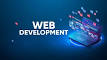
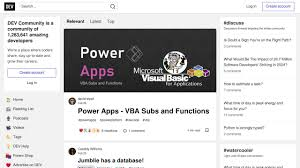
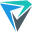
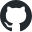
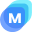
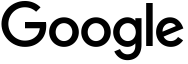
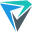
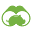
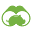
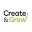
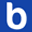
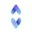
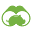
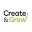
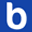
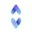
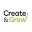
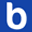
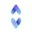

In [93]:
import os, requests
from urllib.parse import quote_plus

api_token = os.getenv("BRIGHTDATA_SERP_API_KEY")
zone = "serp_api1"
q = "Top 5 reddit communities for programming"

encoded_q = quote_plus(q)

resp = requests.post(
    "https://api.brightdata.com/request",
    headers={
        "Authorization": f"Bearer {api_token}",
        "Content-Type": "application/json",
    },
    json={
        "zone": zone,
        "url": f"https://www.google.com/search?q={encoded_q}",
        "country": "us",
        "format": "json",   # required
        # "parse": True     # <-- remove this (not allowed)
    },
    timeout=30,
)

data = resp.json() if "application/json" in resp.headers.get("content-type","") else resp.text
print(type(data), "\n")
print(data)

############################
# data.keys() 
# data.get("organic")
# ###################################
# for result in data.get("organic", []):
#     print(f"Title: {result.get('title')}")
#     print(f"Link: {result.get('link')}")
#     print(f"Snippet: {result.get('snippet')}")
#     print("-" * 40)

In [94]:
# import json
# data = json.dumps(result_data, indent=2)
# print(data)


In [95]:
# # print(data)
# data.keys() 
# data.get("organic")

{
  "status_code": 200,
  "headers": {
    "accept-ch": "Sec-CH-Prefers-Color-Scheme, Downlink, RTT, Sec-CH-UA-Form-Factors, Sec-CH-UA-Platform, Sec-CH-UA-Platform-Version, Sec-CH-UA-Full-Version, Sec-CH-UA-Arch, Sec-CH-UA-Model, Sec-CH-UA-Bitness, Sec-CH-UA-Full-Version-List, Sec-CH-UA-WoW64",
    "alt-svc": "h3=\":443\"; ma=2592000,h3-29=\":443\"; ma=2592000",
    "cache-control": "private, max-age=0",
    "content-security-policy": "object-src 'none';base-uri 'self';script-src 'nonce-Y_dbbKy9tlArE_gMjnCx1A' 'strict-dynamic' 'report-sample' 'unsafe-eval' 'unsafe-inline' https: http:;report-uri https://csp.withgoogle.com/csp/gws/cdt1",
    "content-type": "text/html; charset=UTF-8",
    "cross-origin-opener-policy": "same-origin-allow-popups; report-to=\"gws\"",
    "date": "Thu, 02 Oct 2025 01:52:30 GMT",
    "expires": "-1",
    "permissions-policy": "unload=()",
    "report-to": "{\"group\":\"gws\",\"max_age\":2592000,\"endpoints\":[{\"url\":\"https://csp.withgoogle.com/csp/report-
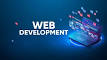
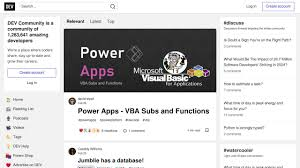
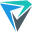
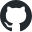
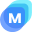
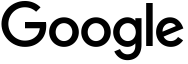
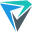
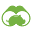
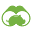
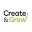
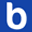
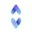
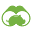
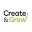
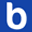
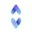
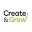
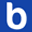
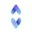

In [96]:
# `resp_data` is the raw dict from requests.post(...).json()
resp_data = data  # whatever variable you used for resp.json()

# If you want to see it, pretty-print WITHOUT overwriting:
import json
print(json.dumps(resp_data, indent=2))

# Unwrap the payload
payload = resp_data.get("body", resp_data)  # some responses nest under "body"

# If body is a JSON string, parse it
if isinstance(payload, str):
    try:
        payload = json.loads(payload)
    except Exception:
        print("No parsed JSON results, raw body HTML below:")
        print(payload[:1000])  # preview
        payload = {}

# Now extract typical SERP fields
organic = []
if isinstance(payload, dict):
    # try common layouts
    if "organic" in payload and isinstance(payload["organic"], list):
        organic = payload["organic"]
    elif "results" in payload and isinstance(payload["results"], dict):
        organic = payload["results"].get("organic", [])
    elif "data" in payload and isinstance(payload["data"], dict):
        organic = payload["data"].get("organic", [])

# Display
for item in organic:
    if isinstance(item, dict):
        print(f"Title:   {item.get('title')}")
        print(f"Link:    {item.get('link') or item.get('url')}")
        print(f"Snippet: {item.get('snippet') or item.get('description')}")
        print("-" * 40)

if not organic:
    print("No 'organic' list found in payload structure.")


{'status_code': 200, 'headers': {'accept-ch': 'Sec-CH-Prefers-Color-Scheme, Downlink, RTT, Sec-CH-UA-Form-Factors, Sec-CH-UA-Platform, Sec-CH-UA-Platform-Version, Sec-CH-UA-Full-Version, Sec-CH-UA-Arch, Sec-CH-UA-Model, Sec-CH-UA-Bitness, Sec-CH-UA-Full-Version-List, Sec-CH-UA-WoW64', 'alt-svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000', 'cache-control': 'private, max-age=0', 'content-security-policy': "object-src 'none';base-uri 'self';script-src 'nonce-Y_dbbKy9tlArE_gMjnCx1A' 'strict-dynamic' 'report-sample' 'unsafe-eval' 'unsafe-inline' https: http:;report-uri https://csp.withgoogle.com/csp/gws/cdt1", 'content-type': 'text/html; charset=UTF-8', 'cross-origin-opener-policy': 'same-origin-allow-popups; report-to="gws"', 'date': 'Thu, 02 Oct 2025 01:52:30 GMT', 'expires': '-1', 'permissions-policy': 'unload=()', 'report-to': '{"group":"gws","max_age":2592000,"endpoints":[{"url":"https://csp.withgoogle.com/csp/report-to/gws/cdt1"}]}', 'server': 'gws', 'set-cookie': ['AEC=AaJma5vu
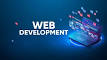
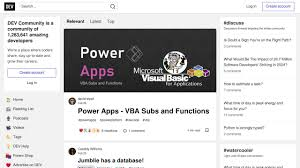
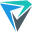
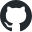
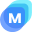
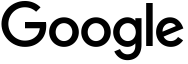
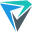
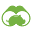
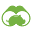
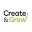
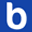
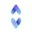
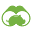
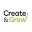
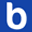
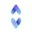
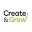
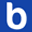
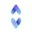